In [5]:
pip install groq 

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from groq import Groq
import os
import time
import random


df = pd.read_parquet("hf://datasets/Whispering-GPT/lex-fridman-podcast/data/train-00000-of-00001-25f40520d4548308.parquet")

/Users/ironman/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
test = str(df['text'][0])

In [28]:
len(test)

84308

In [ ]:
len(test)
# count words in test 
word_count = len(test.split())


In [26]:
word_count

15206

In [ ]:
client = Groq(api_key="API_KEY")

def groq_prompt(prompt_text):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt_text,
            }
        ],
        model="llama-3.1-8b-instant",
        temperature=0.7,
        max_tokens=1000,
        stream=False,
    )
    return chat_completion.choices[0].message.content

def make_request_with_retry(prompt_text, retries=3):
    for attempt in range(retries):
        try:
            response = groq_prompt(prompt_text)
            return response
        except Exception as e:
            if "rate limit reached" in str(e).lower():
                wait_time = random.randint(1, 5)
                print(f"Rate limit hit. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            elif "internal server error" in str(e).lower():
                wait_time = random.randint(5, 15)
                print(f"Internal server error. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                raise e
    print("Max retries reached. Skipping this request.")
    return None

def generate_summary(transcription_text, summary_number):
    prompt = f"""
    This is summary {summary_number} of a podcast transcription.
    Provide a comprehensive summary of the main points, key ideas, and important details from the transcription.
    Ensure that the summary captures the essence of the content without losing relevant information.

    Transcription:
    {transcription_text}

    Provide only the summary content, without any explanations or labels.
    """
    return make_request_with_retry(prompt)

def divide_transcription(text, num_parts):
    length = len(text)
    part_length = length // num_parts
    parts = []
    for i in range(num_parts):
        start = i * part_length
        end = start + part_length if i < num_parts - 1 else length
        parts.append(text[start:end])
    return parts
import time
import random

def make_request_with_retry(prompt_text, max_retries=10, initial_wait=5):
    for attempt in range(max_retries):
        try:
            response = groq_prompt(prompt_text)
            return response
        except Exception as e:
            if "rate limit reached" in str(e).lower():
                wait_time = initial_wait * (2 ** attempt) + random.uniform(0, 1)
                print(f"Rate limit hit. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
            elif "internal server error" in str(e).lower():
                wait_time = initial_wait * (2 ** attempt) + random.uniform(0, 1)
                print(f"Internal server error. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
            else:
                print(f"Unexpected error: {e}. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
    
    print("Max retries reached. Please check your API usage and try again later.")
    return None

def transcription_to_blog(transcription_text, num_parts=4, max_blog_length=3000):
    parts = divide_transcription(transcription_text, num_parts)
    summaries = []
    
    for i, part in enumerate(parts):
        summary = None
        while summary is None:
            summary = generate_summary(part, i+1)
            if summary is None:
                print(f"Retrying summary {i+1} after a short delay...")
                time.sleep(10)  # Wait for 10 seconds before retrying
        summaries.append(summary)

    combined_summaries = " ".join(summaries)

    final_prompt = f"""
    Using the following summaries of a podcast transcription, create a coherent and engaging blog post.
    Ensure the blog post flows smoothly, has a consistent tone, and captures the main ideas and important details from the original content.
    The final blog post should be approximately {max_blog_length} words long.

    Summaries:
    {combined_summaries}

    Provide only the final, complete blog post as the output, without any explanations or labels.
    """
    
    final_blog_post = None
    while final_blog_post is None:
        final_blog_post = make_request_with_retry(final_prompt)
        if final_blog_post is None:
            print("Retrying final blog post generation after a short delay...")
            time.sleep(15)  # Wait for 15 seconds before retrying

    return final_blog_post

In [46]:
def calculate_number_of_summaries(text, max_length_per_summary):
    text_length = len(text)
    num_summaries = (text_length + max_length_per_summary - 1) // max_length_per_summary  # Ceiling division
    return num_summaries

# Example usage
text = a  # The transcription text
max_length_per_summary = 10000  # Define the maximum length of text each summary should cover
num_summaries = calculate_number_of_summaries(text, max_length_per_summary)
print(f"Number of summaries needed: {num_summaries}")

Number of summaries needed: 9


In [ ]:
transcription_text = a
final_blog_post = transcription_to_blog(transcription_text)
print(final_blog_post)

In [16]:
df['text']

0       The following is a conversation with Jed Buck...
1       The following is a conversation with Sergey N...
2       The following is a conversation with Stephen ...
3       I believe our official scientific worldview i...
4       The following is a conversation with Ariol Vi...
                             ...                        
341     The following is a conversation with Francis ...
342     The following is a conversation with Ronald S...
343     The following is a conversation with Eric Wei...
344     The following is a conversation with Thomas S...
345     The following is a conversation with Steven P...
Name: text, Length: 346, dtype: object

In [ ]:
import pandas as pd
import os

def process_and_save_to_csv(row, csv_file):
    if not os.path.exists(csv_file) or row['id'] not in pd.read_csv(csv_file)['id'].values:
        blog_post = transcription_to_blog(row['text'])
        row['blog_post'] = blog_post
        row.to_frame().T.to_csv(csv_file, mode='a', header=not os.path.exists(csv_file), index=False)
        print(f"Processed and saved row with id: {row['id']}")
    else:
        print(f"Row with id: {row['id']} already processed.")

csv_file = 'processed.csv'

df.apply(lambda row: process_and_save_to_csv(row, csv_file), axis=1)

Row with id: TRdL6ZzWBS0 already processed.
Row with id: TPXTmVdlyoc already processed.
Row with id: -t1_ffaFXao already processed.
Row with id: BCdV6BMMpOo already processed.
Row with id: Kedt2or9xlo already processed.
Row with id: M95m2EFb7IQ already processed.
Row with id: R5rNoV1Qy_Q already processed.
Row with id: aSyZvBrPAyk already processed.
Row with id: iwcYp-XT7UI already processed.
Row with id: 8wYZjOzfTUk already processed.
Row with id: _VPxEcT_Adc already processed.
Row with id: Gfr50f6ZBvo already processed.
Row with id: USnqkUAr_3w already processed.
Row with id: pDSEjaDCtOU already processed.
Row with id: gFEE3w7F0ww already processed.
Row with id: orMtwOz6Db0 already processed.
Row with id: nre0QT9LN6w already processed.
Row with id: n2RcVEftY48 already processed.
Row with id: kD5yc1LQrpQ already processed.
Row with id: uX5t8EivCaM already processed.
Row with id: Z_LhPMhkEdw already processed.
Row with id: usDqSEKDVsA already processed.
Row with id: QDN6xvhAw94 already

KeyboardInterrupt: 

In [48]:
import pandas as pd
ndf = pd.read_csv('processed.csv')

In [ ]:
#ndf.to_csv('processed.csv', index=False)

In [6]:
ndf 

,id,channel,channel_id,title,categories,tags,description,text,segments,meta_llama_3.1-8b-instruct,meta_llama_3.1-70b-instruct,meta_llama_3.1-405b-instruct,mistral7b-instruct
0,TRdL6ZzWBS0,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,Jed Buchwald: Isaac Newton and the Philosophy ...,['Science & Technology'],['agi' 'ai' 'ai podcast' 'artificial intellige...,Jed Buchwald is a historian and philosopher of...,The following is a conversation with Jed Buck...,"[{'start': 0.0, 'end': 7.68, 'text': ' The fol...",**The Evolution of Scientific Thought: A Conve...,The Evolution of Scientific Concepts: A Gradua...,The Nature of Scientific Progress: A Conversat...,Title: Unraveling the Threads of Progression:...
1,TPXTmVdlyoc,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"Sergey Nazarov: Chainlink, Smart Contracts, an...",['Science & Technology'],['agi' 'ai' 'ai podcast' 'artificial intellige...,"Sergey Nazarov is the Co-Founder of Chainlink,...",The following is a conversation with Sergey N...,"[{'start': 0.0, 'end': 6.5, 'text': ' The foll...",**The Future of Smart Contracts and Decentrali...,**The Future of Smart Contracts: Revolutionizi...,The Future of Blockchain: How Decentralized Or...,Title: Embracing the Future: The Transformati...
2,-t1_ffaFXao,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,Stephen Wolfram: Fundamental Theory of Physics...,['Science & Technology'],['stephen wolfram' 'artificial intelligence' '...,"Stephen Wolfram is a computer scientist, mathe...",The following is a conversation with Stephen ...,"[{'start': 0.0, 'end': 4.48, 'text': ' The fol...",**Unlocking the Secrets of the Universe: A Con...,**The Quest for a Unified Theory: Unveiling th...,The Quest for a Theory of Everything: A Conver...,Title: Unraveling the Cosmic Code: Stephen Wo...
3,BCdV6BMMpOo,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"Philip Goff: Consciousness, Panpsychism, and t...",['Science & Technology'],['agi' 'ai' 'ai podcast' 'artificial intellige...,Philip Goff is a philosopher of mind and consc...,I believe our official scientific worldview i...,"[{'start': 0.0, 'end': 5.2, 'text': ' I believ...",**The Enigma of Consciousness: Exploring Panps...,The Nature of Consciousness: A Philosophical E...,The Nature of Consciousness: Exploring the Mys...,Title: Unraveling the Enigma of Consciousness...
4,Kedt2or9xlo,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"Oriol Vinyals: DeepMind AlphaStar, StarCraft, ...",['Science & Technology'],[],NaN,The following is a conversation with Ariol Vi...,"[{'start': 0.0, 'end': 3.2800000000000002, 'te...",**Breaking Down the Barriers of Artificial Int...,**The Future of Artificial Intelligence: Insig...,The Power of AI in Gaming: An Exclusive Look a...,Title: AlphaStar: The AI Agent that Conquered...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Whtt2H5_isM,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"David Ferrucci: IBM Watson, Jeopardy & Deep Co...",['Science & Technology'],[],NaN,The following is a conversation with David Fe...,"[{'start': 0.0, 'end': 3.0, 'text': ' The foll...",The Nature of Intelligence: A Conversation wit...,The Concept of Intelligence: Understanding the...,The Evolution of Artificial Intelligence: Unde...,NaN
96,qfKyNxfyWbo,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,Sheldon Solomon: Death and Meaning | Lex Fridm...,['Science & Technology'],['sheldon solomon' 'mortality' 'ernest becker'...,"Sheldon Solomon is a social psychologist, a ph...",The following is a conversation with Sheldon ...,"[{'start': 0.0, 'end': 5.76, 'text': ' The fol...","**The Human Condition: Exploring Death, Fear, ...",The Human Condition: How the Fear of Death Sha...,The Role of Death in Life: A Conversation with...,NaN
97,KZkYSSE8HHI,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,Jeff Atwood: Stack Overflow and Coding Horror ...,['Science & Technology'],[],NaN,The following is a conversation with Jeff Atw...,"[{'start': 0.0, 'end': 2.4, 'text': ' The foll...",**The Power of Community and Leadership in Cre...,**The Evolution of Online Communities: A Conve...,"The Art of

In [11]:
ndf['mistral7b-instruct']=np.nan

In [ ]:
from groq import Groq
import os
import time
import random
import openai


# Initialize SambaNova client
sambanova_client = openai.OpenAI(
    api_key="API_KEY",
    base_url="https://glhf.chat/api/openai/v1",
)


def sambanova_prompt(prompt_text):
    response = sambanova_client.chat.completions.create(
        model="hf:mistralai/Mistral-7B-Instruct-v0.3",
        messages=[{"role":"system","content":"You are a helpful assistant"},{"role":"user","content":prompt_text}],
        temperature=0.1,
        top_p=0.1
    )
    return response.choices[0].message.content 

def make_request_with_retry(prompt_text, retries=3, use_groq=True):
    for attempt in range(retries):
        try:
            if use_groq:
                response = groq_prompt(prompt_text)
            else:
                response = sambanova_prompt(prompt_text)
            return response
        except Exception as e:
            if "rate limit reached" in str(e).lower():
                wait_time = random.randint(1, 5)
                print(f"Rate limit hit. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            elif "internal server error" in str(e).lower():
                wait_time = random.randint(5, 15)
                print(f"Internal server error. Retrying in {wait_time} seconds...")
                time.sleep(wait_time)
            else:
                time.sleep(60)
    print("Max retries reached. Skipping this request.")
    return None

def generate_summary(transcription_text, summary_number, use_groq=True):
    prompt = f"""
    This is summary {summary_number} of a podcast transcription.
    Provide a comprehensive summary of the main points, key ideas, and important details from the transcription.
    Ensure that the summary captures the essence of the content without losing relevant information.

    Transcription:
    {transcription_text}

    Provide only the summary content, without any explanations or labels.
    """
    return make_request_with_retry(prompt, use_groq=use_groq)

def divide_transcription(text, num_parts):
    length = len(text)
    part_length = length // num_parts
    parts = []
    for i in range(num_parts):
        start = i * part_length
        end = start + part_length if i < num_parts - 1 else length
        parts.append(text[start:end])
    return parts

def transcription_to_blog(transcription_text, num_parts=6, max_blog_length=3000, use_groq=False):
    parts = divide_transcription(transcription_text, num_parts)
    summaries = []
    
    for i, part in enumerate(parts):
        summary = None
        while summary is None:
            summary = generate_summary(part, i+1, use_groq=use_groq)
            if summary is None:
                print(f"Retrying summary {i+1} after a short delay...")
                time.sleep(10)  # Wait for 10 seconds before retrying
        summaries.append(summary)

    combined_summaries = " ".join(summaries)

    final_prompt = f"""
    Using the following summaries of a podcast transcription, create a coherent and engaging blog post.
    Ensure the blog post flows smoothly, has a consistent tone, and captures the main ideas and important details from the original content.
    The final blog post should be approximately {max_blog_length} words long.

    Summaries:
    {combined_summaries}

    Provide only the final, complete blog post as the output, without any explanations or labels.
    """
    
    final_blog_post = None
    while final_blog_post is None:
        final_blog_post = make_request_with_retry(final_prompt, use_groq=use_groq)
        if final_blog_post is None:
            print("Retrying final blog post generation after a short delay...")
            time.sleep(15)  # Wait for 15 seconds before retrying

    return final_blog_post


In [ ]:
#ndf['meta_llama_3.1-70b-instruct']=np.nan # change model type as per requirement

In [7]:
ndf 

,id,channel,channel_id,title,categories,tags,description,text,segments,meta_llama_3.1-8b-instruct,meta_llama_3.1-70b-instruct,meta_llama_3.1-405b-instruct,mistral7b-instruct
0,TRdL6ZzWBS0,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,Jed Buchwald: Isaac Newton and the Philosophy ...,['Science & Technology'],['agi' 'ai' 'ai podcast' 'artificial intellige...,Jed Buchwald is a historian and philosopher of...,The following is a conversation with Jed Buck...,"[{'start': 0.0, 'end': 7.68, 'text': ' The fol...",**The Evolution of Scientific Thought: A Conve...,The Evolution of Scientific Concepts: A Gradua...,The Nature of Scientific Progress: A Conversat...,Title: Unraveling the Threads of Progression:...
1,TPXTmVdlyoc,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"Sergey Nazarov: Chainlink, Smart Contracts, an...",['Science & Technology'],['agi' 'ai' 'ai podcast' 'artificial intellige...,"Sergey Nazarov is the Co-Founder of Chainlink,...",The following is a conversation with Sergey N...,"[{'start': 0.0, 'end': 6.5, 'text': ' The foll...",**The Future of Smart Contracts and Decentrali...,**The Future of Smart Contracts: Revolutionizi...,The Future of Blockchain: How Decentralized Or...,Title: Embracing the Future: The Transformati...
2,-t1_ffaFXao,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,Stephen Wolfram: Fundamental Theory of Physics...,['Science & Technology'],['stephen wolfram' 'artificial intelligence' '...,"Stephen Wolfram is a computer scientist, mathe...",The following is a conversation with Stephen ...,"[{'start': 0.0, 'end': 4.48, 'text': ' The fol...",**Unlocking the Secrets of the Universe: A Con...,**The Quest for a Unified Theory: Unveiling th...,The Quest for a Theory of Everything: A Conver...,Title: Unraveling the Cosmic Code: Stephen Wo...
3,BCdV6BMMpOo,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"Philip Goff: Consciousness, Panpsychism, and t...",['Science & Technology'],['agi' 'ai' 'ai podcast' 'artificial intellige...,Philip Goff is a philosopher of mind and consc...,I believe our official scientific worldview i...,"[{'start': 0.0, 'end': 5.2, 'text': ' I believ...",**The Enigma of Consciousness: Exploring Panps...,The Nature of Consciousness: A Philosophical E...,The Nature of Consciousness: Exploring the Mys...,Title: Unraveling the Enigma of Consciousness...
4,Kedt2or9xlo,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"Oriol Vinyals: DeepMind AlphaStar, StarCraft, ...",['Science & Technology'],[],NaN,The following is a conversation with Ariol Vi...,"[{'start': 0.0, 'end': 3.2800000000000002, 'te...",**Breaking Down the Barriers of Artificial Int...,**The Future of Artificial Intelligence: Insig...,The Power of AI in Gaming: An Exclusive Look a...,Title: AlphaStar: The AI Agent that Conquered...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Whtt2H5_isM,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"David Ferrucci: IBM Watson, Jeopardy & Deep Co...",['Science & Technology'],[],NaN,The following is a conversation with David Fe...,"[{'start': 0.0, 'end': 3.0, 'text': ' The foll...",The Nature of Intelligence: A Conversation wit...,The Concept of Intelligence: Understanding the...,The Evolution of Artificial Intelligence: Unde...,NaN
96,qfKyNxfyWbo,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,Sheldon Solomon: Death and Meaning | Lex Fridm...,['Science & Technology'],['sheldon solomon' 'mortality' 'ernest becker'...,"Sheldon Solomon is a social psychologist, a ph...",The following is a conversation with Sheldon ...,"[{'start': 0.0, 'end': 5.76, 'text': ' The fol...","**The Human Condition: Exploring Death, Fear, ...",The Human Condition: How the Fear of Death Sha...,The Role of Death in Life: A Conversation with...,NaN
97,KZkYSSE8HHI,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,Jeff Atwood: Stack Overflow and Coding Horror ...,['Science & Technology'],[],NaN,The following is a conversation with Jeff Atw...,"[{'start': 0.0, 'end': 2.4, 'text': ' The foll...",**The Power of Community and Leadership in Cre...,**The Evolution of Online Communities: A Conve...,"The Art of

In [ ]:
#ndf = pd.read_csv('processed copy.csv')
#ndf['meta_llama_3.1-405b-instruct']=np.nan
#ndf.to_csv('processed.csv', index=False)

In [ ]:
import pandas as pd
import os
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

def process_and_update_csv(row, csv_file):
    # Load the existing CSV if it exists
    if os.path.exists(csv_file):
        existing_df = pd.read_csv(csv_file)
    else:
        existing_df = pd.DataFrame(columns=ndf.columns)  

    if row['mistral7b-instruct'] and not pd.isna(row['mistral7b-instruct']): # change model row name as per requirement
        print(f"Row already processed for id: {row['id']}")
        return  # Skip this row
    
    blog_post = transcription_to_blog(row['text'])
    if blog_post:
        row['mistral7b-instruct'] = blog_post 

        if row['id'] in existing_df['id'].values:
            existing_df.loc[existing_df['id'] == row['id'], 'mistral7b-instruct'] = blog_post
        else:
            existing_df = pd.concat([existing_df, row.to_frame().T], ignore_index=True)
        
        existing_df.to_csv(csv_file, index=False)
        print(f"Processed and updated row with id: {row['id']}")
        
    else:
        print(f"Failed to process row with id: {row['id']}")
        time.sleep(60)

csv_file = 'processed.csv'

ndf.apply(lambda row: process_and_update_csv(row, csv_file), axis=1)


Row already processed for id: TRdL6ZzWBS0
Row already processed for id: TPXTmVdlyoc
Processed and updated row with id: -t1_ffaFXao
Processed and updated row with id: BCdV6BMMpOo
Processed and updated row with id: Kedt2or9xlo
Processed and updated row with id: M95m2EFb7IQ
Processed and updated row with id: R5rNoV1Qy_Q
Processed and updated row with id: aSyZvBrPAyk
Processed and updated row with id: iwcYp-XT7UI
Processed and updated row with id: 8wYZjOzfTUk


KeyboardInterrupt: 

In [ ]:
ndf 

In [22]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            100 non-null    object
 1   channel                       100 non-null    object
 2   channel_id                    100 non-null    object
 3   title                         100 non-null    object
 4   categories                    100 non-null    object
 5   tags                          100 non-null    object
 6   description                   78 non-null     object
 7   text                          100 non-null    object
 8   segments                      100 non-null    object
 9   meta_llama_3.1-8b-instruct    100 non-null    object
 10  meta_llama_3.1-70b-instruct   100 non-null    object
 11  meta_llama_3.1-405b-instruct  100 non-null    object
 12  mistral7b-instruct            10 non-null     object
dtypes: object(13)
memory 

In [25]:
ndf['text'].apply(len).mean()
avg_word_length = ndf['text'].apply(lambda x: len(x.split())).mean()
print(f"Average word length: {avg_word_length}")

Average word length: 22812.86


In [29]:
ndf['text'][10]

" The following is a conversation with Peter Norvig. He's the director of research at Google and the coauthor with Stuart Russell of the book Artificial Intelligence and Modern Approach. An educated and inspired a whole generation of researchers, including myself, to get into the field of artificial intelligence. This is the artificial intelligence podcast. If you enjoy it, subscribe on YouTube, give five stars on iTunes, support on Patreon, or simply connect with me on Twitter at Lex Friedman, spelled F R I D M A N. And now here's my conversation with Peter Norvig. Most researchers in the AI community, including myself, own all three editions, red, green and blue, of the Artificial Intelligence and Modern Approach. It's a field defining textbook, as many people are aware, that you wrote with Stuart Russell. How has the book changed and how have you changed in relation to it from the first edition to the second to the third and now fourth edition as you work on it? Yeah. So it's been a

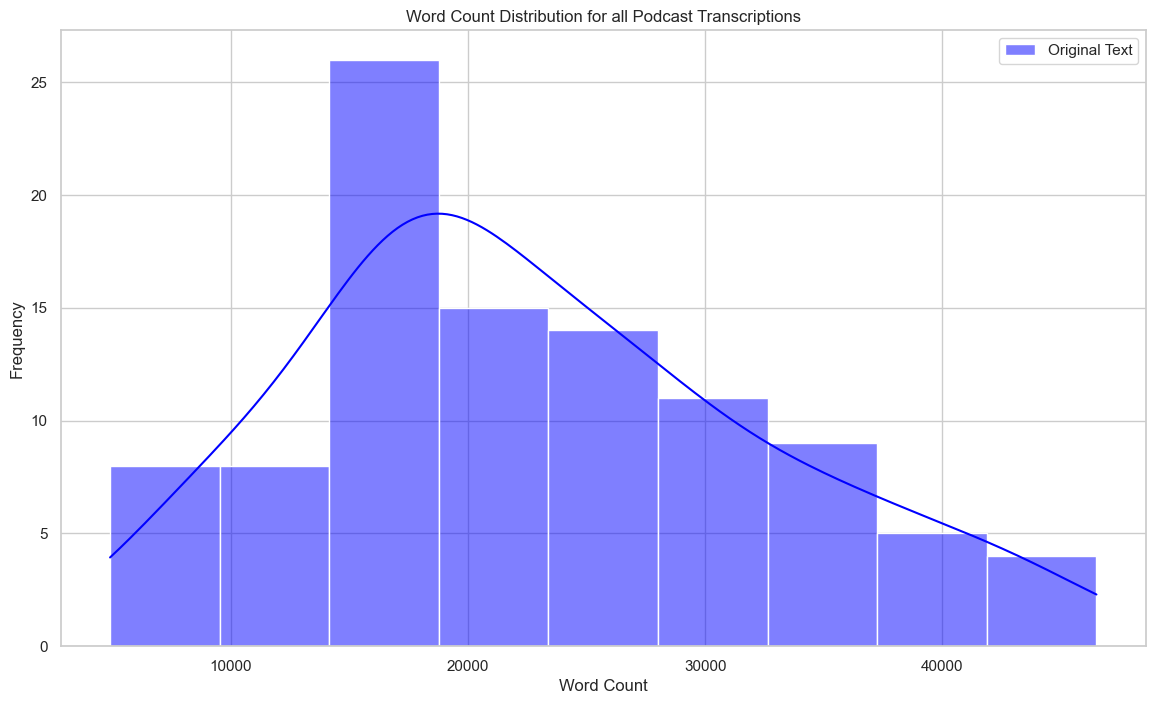

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for seaborn
sns.set(style="whitegrid")

# Calculate word counts for the 'text' column
ndf['text_word_count'] = ndf['text'].apply(lambda x: len(x.split()))

# Plot word count distribution for the 'text' column
plt.figure(figsize=(14, 8))
sns.histplot(ndf['text_word_count'], kde=True, color='blue', label='Original Text')
plt.title('Word Count Distribution for all Podcast Transcriptions')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()



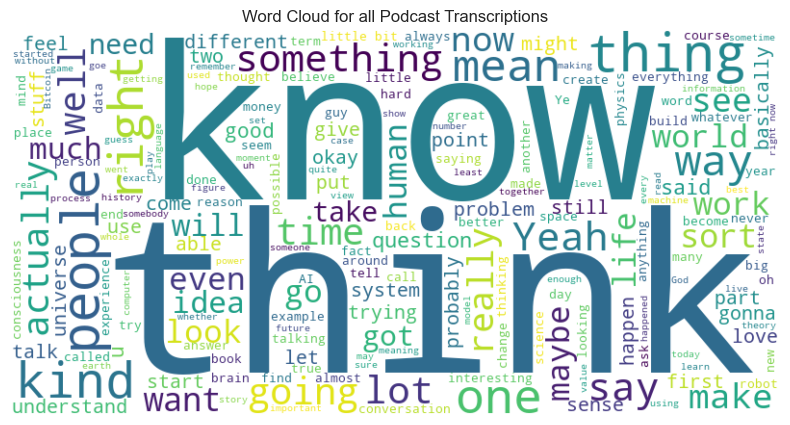

In [9]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

# Combine all text data into a single string
all_text = ' '.join(ndf['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for all Podcast Transcriptions')
plt.show()

In [10]:
# Check the first few rows of the 'segments' column
print(ndf['segments'].head())


0    [{'start': 0.0, 'end': 7.68, 'text': ' The fol...
1    [{'start': 0.0, 'end': 6.5, 'text': ' The foll...
2    [{'start': 0.0, 'end': 4.48, 'text': ' The fol...
3    [{'start': 0.0, 'end': 5.2, 'text': ' I believ...
4    [{'start': 0.0, 'end': 3.2800000000000002, 'te...
Name: segments, dtype: object


In [19]:
ndf['segments'][0]

[]

In [31]:
ndf 

,id,channel,channel_id,title,categories,tags,description,text,segments,meta_llama_3.1-8b-instruct,meta_llama_3.1-70b-instruct,meta_llama_3.1-405b-instruct,mistral7b-instruct,overall_sentiment,readability_text
0,TRdL6ZzWBS0,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,Jed Buchwald: Isaac Newton and the Philosophy ...,['Science & Technology'],['agi' 'ai' 'ai podcast' 'artificial intellige...,Jed Buchwald is a historian and philosopher of...,The following is a conversation with Jed Buck...,[],**The Evolution of Scientific Thought: A Conve...,The Evolution of Scientific Concepts: A Gradua...,The Nature of Scientific Progress: A Conversat...,Title: Unraveling the Threads of Progression:...,0.120371,71.85
1,TPXTmVdlyoc,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"Sergey Nazarov: Chainlink, Smart Contracts, an...",['Science & Technology'],['agi' 'ai' 'ai podcast' 'artificial intellige...,"Sergey Nazarov is the Co-Founder of Chainlink,...",The following is a conversation with Sergey N...,[],**The Future of Smart Contracts and Decentrali...,**The Future of Smart Contracts: Revolutionizi...,The Future of Blockchain: How Decentralized Or...,Title: Embracing the Future: The Transformati...,0.191490,69.01
2,-t1_ffaFXao,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,Stephen Wolfram: Fundamental Theory of Physics...,['Science & Technology'],['stephen wolfram' 'artificial intelligence' '...,"Stephen Wolfram is a computer scientist, mathe...",The following is a conversation with Stephen ...,[],**Unlocking the Secrets of the Universe: A Con...,**The Quest for a Unified Theory: Unveiling th...,The Quest for a Theory of Everything: A Conver...,Title: Unraveling the Cosmic Code: Stephen Wo...,0.133685,71.75
3,BCdV6BMMpOo,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"Philip Goff: Consciousness, Panpsychism, and t...",['Science & Technology'],['agi' 'ai' 'ai podcast' 'artificial intellige...,Philip Goff is a philosopher of mind and consc...,I believe our official scientific worldview i...,[],**The Enigma of Consciousness: Exploring Panps...,The Nature of Consciousness: A Philosophical E...,The Nature of Consciousness: Exploring the Mys...,Title: Unraveling the Enigma of Consciousness...,0.126979,71.34
4,Kedt2or9xlo,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"Oriol Vinyals: DeepMind AlphaStar, StarCraft, ...",['Science & Technology'],[],NaN,The following is a conversation with Ariol Vi...,[],**Breaking Down the Barriers of Artificial Int...,**The Future of Artificial Intelligence: Insig...,The Power of AI in Gaming: An Exclusive Look a...,Title: AlphaStar: The AI Agent that Conquered...,0.140910,70.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Whtt2H5_isM,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"David Ferrucci: IBM Watson, Jeopardy & Deep Co...",['Science & Technology'],[],NaN,The following is a conversation with David Fe...,[],The Nature of Intelligence: A Conversation wit...,The Concept of Intelligence: Understanding the...,The Evolution of Artificial Intelligence: Unde...,NaN,0.124577,71.95
96,qfKyNxfyWbo,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,Sheldon Solomon: Death and Meaning | Lex Fridm...,['Science & Technology'],['sheldon solomon' 'mortality' 'ernest becker'...,"Sheldon Solomon is a social psychologist, a ph...",The following is a conversation with Sheldon ...,[],"**The Human Condition: Exploring Death, Fear, ...",The Human Condition: How the Fear of Death Sha...,The Role of Death in Life: A Conversation with...,NaN,0.140933,71.85
97,KZkYSSE8HHI,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,Jeff Atwood: Stack Overflow and Coding Horror ...,['Science & Technology'],[],NaN,The following is a conversation with Jeff Atw...,[],**The Power of Community and Leadership in Cre...,**The Evolution of Online Communities: A Conve...,"The Art of Programming, Leadership, and Online...",NaN,0.183042,83.25
98,A22Ej6kb2wo,Lex Fridman,UCSHZKyawb77ixDdsGog4iWA,"Russ Tedrake: Underactuated Robotics, Control,...",['Science & Technology'],['russ tedrake' 'artificial intelligence' 'agi...,Russ 

In [49]:
ndf['Guest'] = ndf['title'].apply(lambda x: ' '.join(x.split()[:2]))
ndf['Guest'] = ndf['Guest'].str.rstrip(':')

In [57]:
ndf = ndf.drop_duplicates(subset='Guest')

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_72560/3847721300.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['overall_sentiment'] = ndf['text'].apply(lambda text: TextBlob(text).sentiment.polarity)
/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_72560/3847721300.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['Guest'] = ndf['Guest'].astype(str)


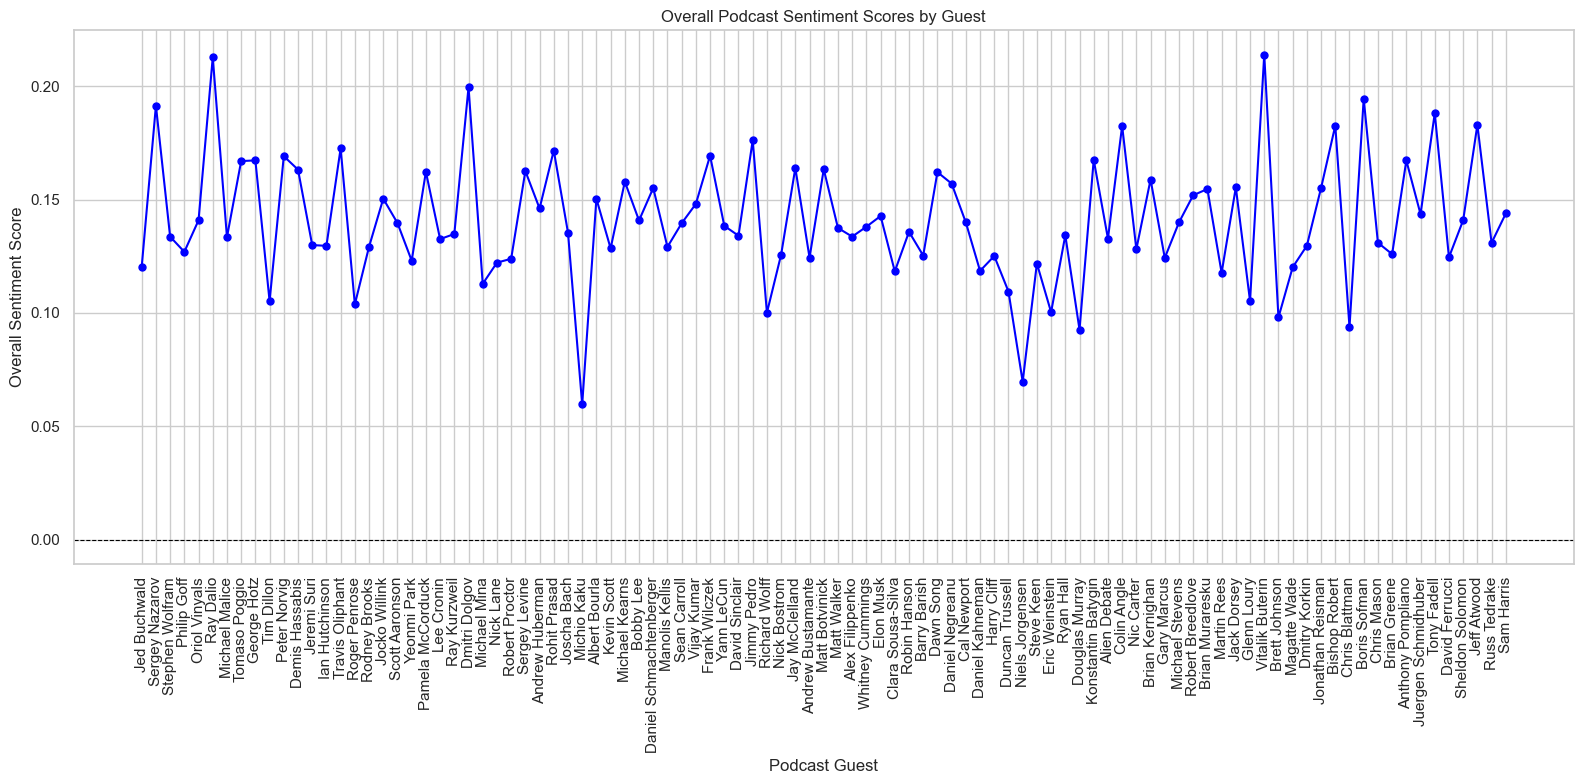

In [ ]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import ast

ndf['overall_sentiment'] = ndf['text'].apply(lambda text: TextBlob(text).sentiment.polarity)

ndf['Guest'] = ndf['Guest'].astype(str)

plt.figure(figsize=(16, 8))  

plt.plot(ndf['Guest'], ndf['overall_sentiment'], marker='o', color='blue', linestyle='-', markersize=5)

plt.title('Overall Podcast Sentiment Scores by Guest')
plt.xlabel('Podcast Guest')
plt.ylabel('Overall Sentiment Score')

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_72560/100791123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['readability_text'] = ndf['text'].apply(flesch_reading_ease)


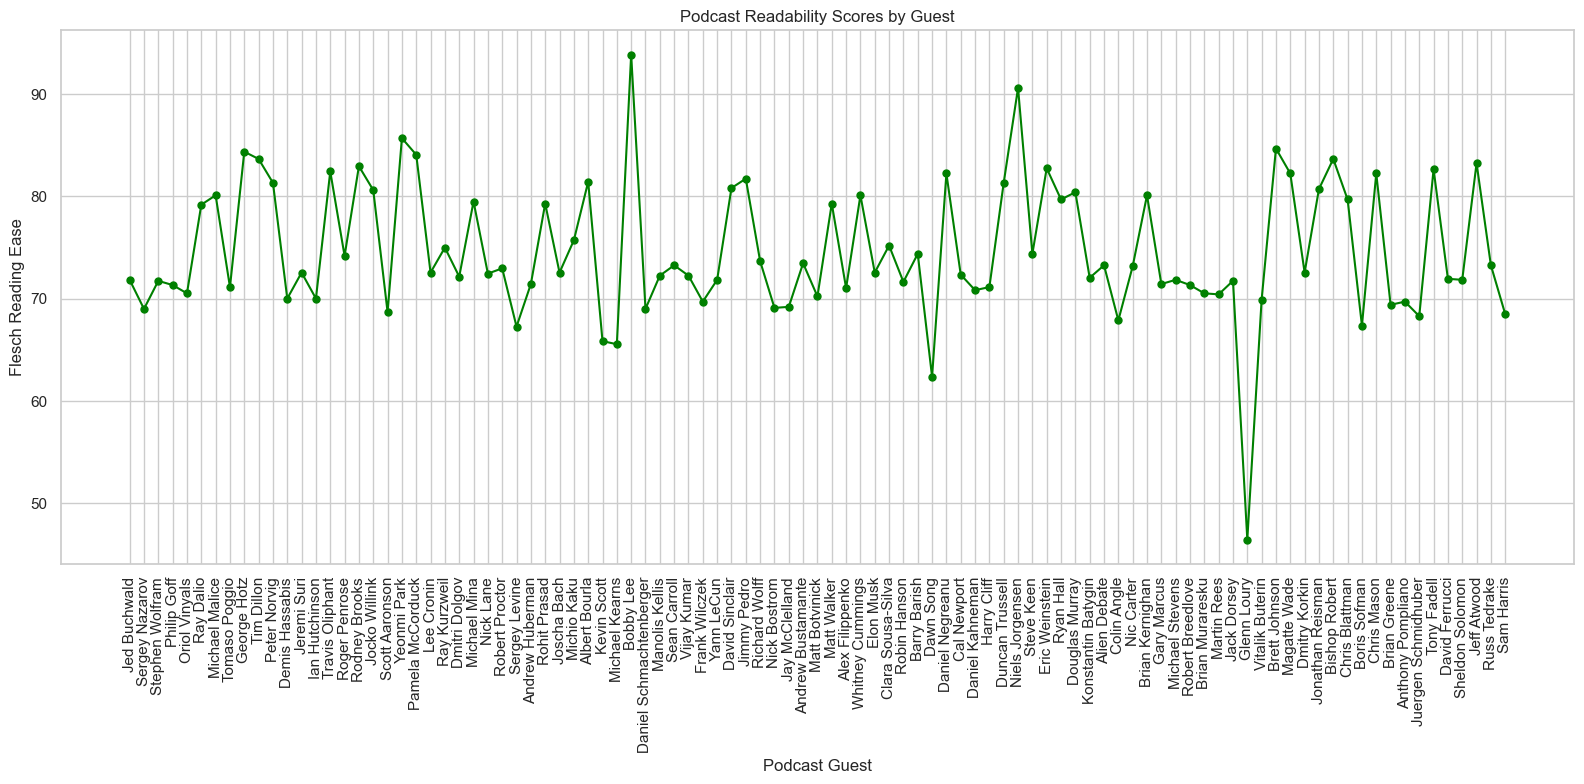

In [ ]:
from textstat import flesch_reading_ease
import matplotlib.pyplot as plt

ndf['readability_text'] = ndf['text'].apply(flesch_reading_ease)
ndf = ndf.dropna(subset=['readability_text'])

ndf['Guest'] = ndf['Guest'].astype(str)

plt.figure(figsize=(16, 8)) 

plt.plot(ndf['Guest'], ndf['readability_text'], marker='o', color='green', linestyle='-', markersize=5)

plt.title('Podcast Readability Scores by Guest')
plt.xlabel('Podcast Guest')
plt.ylabel('Flesch Reading Ease')

plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


In [72]:
ndf[['overall_sentiment', 'readability_text']].to_csv('sentiment_readability_scores.csv', index=False)

In [51]:
pip install textstat

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
